# Stained Glass Art via Genetic Algorithm

In [1]:
!pip install numpy opencv-python pillow scipy matplotlib imageio

In [2]:
import numpy as np
import cv2
import random
import os
import pickle
from datetime import datetime
from PIL import Image, ImageDraw
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
from IPython.display import clear_output
import imageio

## Configuration

In [ ]:
IMAGE_PATH = "images/lisa.jpg"
OUTPUT_BASE = "./output"

config = {
    "target_size": 100,
    "contrast": 1.0,
    "saturation": 1.0,
    
    "initial_points": 250,
    "population_size": 200,
    
    "phases": [
        # Phase 1: 250 points, high exploration
        {"gens": 1500, "rate": 0.05, "sigma": 0.5, "action": None},
        {"gens": 1, "rate": 0.05, "sigma": 0.5, "action": "duplicate"},
        
        # Phase 2: 500 points
        {"gens": 1200, "rate": 0.05, "sigma": 0.5, "action": None},
        {"gens": 150, "rate": 0.04, "sigma": 0.4, "action": "shrink"},
        {"gens": 1, "rate": 0.04, "sigma": 0.4, "action": "duplicate"},
        
        # Phase 3: ~900 points
        {"gens": 1500, "rate": 0.04, "sigma": 0.4, "action": None},
        {"gens": 150, "rate": 0.03, "sigma": 0.35, "action": "shrink"},
        {"gens": 1, "rate": 0.03, "sigma": 0.35, "action": "duplicate"},
        
        # Phase 4: ~1600 points
        {"gens": 2000, "rate": 0.03, "sigma": 0.35, "action": None},
        {"gens": 200, "rate": 0.02, "sigma": 0.3, "action": "shrink"},
        
        # Phase 5: Fine tuning
        {"gens": 2500, "rate": 0.02, "sigma": 0.3, "action": None},
        {"gens": 200, "rate": 0.015, "sigma": 0.25, "action": "shrink"},
        
        # Phase 6: Polish
        {"gens": 3000, "rate": 0.01, "sigma": 0.2, "action": None},
        {"gens": 1, "rate": 0.01, "sigma": 0.2, "action": "duplicate"},
        
        # Phase 7: More points, fine polish
        {"gens": 3000, "rate": 0.005, "sigma": 0.15, "action": None},
        
        # Phase 8: Final refinement
        {"gens": 4000, "rate": 0.002, "sigma": 0.1, "action": None},
    ],
    
    "survive_fraction": 0.025,
    "position_delta": 10,
    "color_delta": 25,
    "checkpoint_every": 100,
    "display_every": 25,
}

## Preprocessing

In [4]:
def load_and_preprocess(path, target_size, contrast, saturation):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Could not load: {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    h, w = img.shape[:2]
    scale = target_size / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)
    img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    if contrast != 1.0:
        img = cv2.convertScaleAbs(img, alpha=contrast, beta=10)
    
    if saturation != 1.0:
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float32)
        hsv[:, :, 1] *= saturation
        hsv[:, :, 1] = np.clip(hsv[:, :, 1], 0, 255)
        img = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)
    
    return Image.fromarray(img)

## Voronoi Painting

In [5]:
def create_point(img_width, img_height):
    return {
        "x": random.randint(0, img_width - 1),
        "y": random.randint(0, img_height - 1),
        "color": (
            random.randint(0, 255),
            random.randint(0, 255),
            random.randint(0, 255),
            255
        )
    }


def copy_point(p):
    return {"x": p["x"], "y": p["y"], "color": p["color"]}


def mutate_point(point, img_width, img_height, sigma, position_delta, color_delta):
    if random.random() < 0.5:
        point["x"] += int(random.randint(-position_delta, position_delta) * sigma)
        point["y"] += int(random.randint(-position_delta, position_delta) * sigma)
        point["x"] = max(0, min(img_width - 1, point["x"]))
        point["y"] = max(0, min(img_height - 1, point["y"]))
    else:
        r, g, b, a = point["color"]
        r += int(random.randint(-color_delta, color_delta) * sigma)
        g += int(random.randint(-color_delta, color_delta) * sigma)
        b += int(random.randint(-color_delta, color_delta) * sigma)
        point["color"] = (
            max(0, min(255, r)),
            max(0, min(255, g)),
            max(0, min(255, b)),
            255
        )


def create_painting(num_points, img_width, img_height):
    return {
        "points": [create_point(img_width, img_height) for _ in range(num_points)],
        "width": img_width,
        "height": img_height,
        "fitness": None
    }


def copy_painting(painting):
    return {
        "points": [copy_point(p) for p in painting["points"]],
        "width": painting["width"],
        "height": painting["height"],
        "fitness": painting["fitness"]
    }


def mutate_painting(painting, rate, sigma, position_delta, color_delta):
    num_mutations = max(1, int(rate * len(painting["points"])))
    indices = random.sample(range(len(painting["points"])), min(num_mutations, len(painting["points"])))
    for i in indices:
        mutate_point(painting["points"][i], painting["width"], painting["height"], sigma, position_delta, color_delta)
    painting["fitness"] = None


def duplicate_points(painting):
    original = painting["points"][:]
    for p in original:
        painting["points"].append(copy_point(p))
    painting["fitness"] = None


def shrink_painting(painting):
    if len(painting["points"]) > 10:
        idx = random.randint(0, len(painting["points"]) - 1)
        painting["points"].pop(idx)
    painting["fitness"] = None


def render_painting(painting, scale=1, with_edges=True):
    w, h = painting["width"] * scale, painting["height"] * scale
    image = Image.new("RGBA", (w, h), (128, 128, 128, 255))
    
    if len(painting["points"]) < 3:
        return image
    
    coords = [(p["x"], p["y"]) for p in painting["points"]]
    
    try:
        vor = Voronoi(coords)
    except:
        return image
    
    draw = ImageDraw.Draw(image)
    
    for point, region_idx in zip(painting["points"], vor.point_region):
        region = vor.regions[region_idx]
        if -1 in region or len(region) == 0:
            continue
        polygon = [(vor.vertices[i][0] * scale, vor.vertices[i][1] * scale) for i in region]
        draw.polygon(polygon, fill=point["color"])
        if with_edges:
            draw.polygon(polygon, outline=(30, 30, 30, 255))
    
    return image


def calculate_fitness(painting, target_img):
    rendered = render_painting(painting, scale=1, with_edges=False).convert("RGB")
    rendered_arr = np.array(rendered, dtype=np.float32)
    target_arr = np.array(target_img, dtype=np.float32)
    
    if rendered_arr.shape != target_arr.shape:
        return float("inf")
    
    diff = np.abs(rendered_arr - target_arr)
    painting["fitness"] = np.mean(diff)
    return painting["fitness"]

## Evolution

In [ ]:
def evaluate_population(population, target_img):
    for ind in population:
        if ind["fitness"] is None:
            calculate_fitness(ind, target_img)


def select_best(population):
    return min(population, key=lambda x: x["fitness"] if x["fitness"] else float("inf"))


def mate(parent_a, parent_b):
    child_a = {
        "points": [],
        "width": parent_a["width"],
        "height": parent_a["height"],
        "fitness": None
    }
    child_b = {
        "points": [],
        "width": parent_a["width"],
        "height": parent_a["height"],
        "fitness": None
    }
    for p_a, p_b in zip(parent_a["points"], parent_b["points"]):
        if random.random() < 0.5:
            child_a["points"].append(copy_point(p_a))
            child_b["points"].append(copy_point(p_b))
        else:
            child_a["points"].append(copy_point(p_b))
            child_b["points"].append(copy_point(p_a))
    return child_a, child_b


def save_checkpoint(population, history, config, run_dir, generation):
    path = os.path.join(run_dir, f"checkpoint_{generation:05d}.pkl")
    with open(path, "wb") as f:
        pickle.dump({
            "generation": generation,
            "population": population,
            "history": history,
            "config": config
        }, f)
    return path


def plot_stats(history, target_img, best, global_gen, rate, sigma, run_dir):
    clean_history = [h for h in history if h is not None]
    
    fig = plt.figure(figsize=(18, 10))
    
    ax1 = fig.add_subplot(2, 3, 1)
    ax2 = fig.add_subplot(2, 3, 2)
    ax3 = fig.add_subplot(2, 3, 3)
    ax4 = fig.add_subplot(2, 3, 4)
    ax5 = fig.add_subplot(2, 3, 5)
    ax6 = fig.add_subplot(2, 3, 6)
    
    ax1.imshow(target_img)
    ax1.set_title("Target")
    ax1.axis("off")
    
    ax2.imshow(render_painting(best, scale=2, with_edges=True))
    ax2.set_title(f"Gen {global_gen} | Pts: {len(best['points'])} | Fit: {best['fitness']:.2f}")
    ax2.axis("off")
    
    ax3.imshow(render_painting(best, scale=2, with_edges=False))
    ax3.set_title("Without Edges")
    ax3.axis("off")
    
    ax4.plot(clean_history, 'b-', linewidth=0.5)
    ax4.set_title(f"Fitness History (rate={rate}, sigma={sigma})")
    ax4.set_xlabel("Generation")
    ax4.set_ylabel("Fitness")
    ax4.grid(True, alpha=0.3)
    
    recent = clean_history[-1000:] if len(clean_history) > 1000 else clean_history
    recent_start = max(0, len(clean_history) - 1000)
    ax5.plot(range(recent_start, recent_start + len(recent)), recent, 'g-', linewidth=1)
    ax5.set_title("Recent Fitness (last 1000 gens)")
    ax5.set_xlabel("Generation")
    ax5.set_ylabel("Fitness")
    ax5.grid(True, alpha=0.3)
    
    if len(clean_history) > 100:
        window = 100
        improvements = [clean_history[i] - clean_history[i+window] for i in range(len(clean_history) - window)]
        ax6.plot(range(window, len(clean_history)), improvements, 'r-', linewidth=0.5)
        ax6.axhline(y=0, color='k', linestyle='--', alpha=0.3)
        ax6.set_title(f"Improvement Rate (per {window} gens)")
        ax6.set_xlabel("Generation")
        ax6.set_ylabel("Fitness Decrease")
        ax6.grid(True, alpha=0.3)
    else:
        ax6.text(0.5, 0.5, "Need more data", ha='center', va='center', transform=ax6.transAxes)
        ax6.set_title("Improvement Rate")
    
    plt.tight_layout()
    plt.savefig(os.path.join(run_dir, f"stats_{global_gen:05d}.png"), dpi=100)
    plt.show()


def run_phase(population, target_img, config, phase, global_gen, run_dir, history):
    gens = phase["gens"]
    rate = phase["rate"]
    sigma = phase["sigma"]
    action = phase.get("action")
    
    for g in range(gens):
        
        if action == "shrink":
            for ind in population:
                shrink_painting(ind)
        
        
        population.sort(key=lambda x: x["fitness"] if x["fitness"] else float("inf"))
        best = population[0]
        history.append(best["fitness"])
        
        
        n_survive = max(2, int(len(population) * config["survive_fraction"]))
        survivors = population[:n_survive]
        
        
        new_population = [copy_painting(survivors[0])]  
        while len(new_population) < config["population_size"]:
            mom = survivors[0]
            dad = random.choice(survivors)
            child_a, child_b = mate(mom, dad)
            mutate_painting(child_a, rate, sigma, config["position_delta"], config["color_delta"])
            mutate_painting(child_b, rate, sigma, config["position_delta"], config["color_delta"])
            new_population.append(child_a)
            if len(new_population) < config["population_size"]:
                new_population.append(child_b)
        
        population = new_population
        evaluate_population(population, target_img)
        
        
        if global_gen % config["display_every"] == 0:
            clear_output(wait=True)
            best = select_best(population)
            plot_stats(history, target_img, best, global_gen, rate, sigma, run_dir)
        
        
        if global_gen % config["checkpoint_every"] == 0:
            best = select_best(population)
            img = render_painting(best, scale=2, with_edges=True)
            img.save(os.path.join(run_dir, f"gen_{global_gen:05d}.png"))
            save_checkpoint(population, history, config, run_dir, global_gen)
        
        global_gen += 1
    
    
    if action == "duplicate":
        print(f"\n=== DUPLICATING POINTS at gen {global_gen} ===")
        for ind in population:
            duplicate_points(ind)
        evaluate_population(population, target_img)
        print(f"Now at {len(population[0]['points'])} points")
    
    return population, global_gen, history

## Load Image

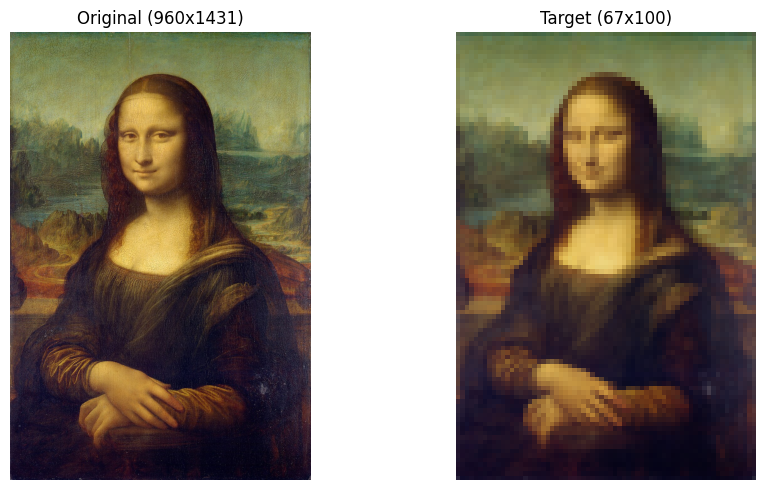


Total generations planned: 8903


In [7]:
original = Image.open(IMAGE_PATH)
target_img = load_and_preprocess(
    IMAGE_PATH,
    config["target_size"],
    config["contrast"],
    config["saturation"]
)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original)
axes[0].set_title(f"Original ({original.size[0]}x{original.size[1]})")
axes[0].axis("off")
axes[1].imshow(target_img)
axes[1].set_title(f"Target ({target_img.size[0]}x{target_img.size[1]})")
axes[1].axis("off")
plt.tight_layout()
plt.show()

total_gens = sum(p["gens"] for p in config["phases"])
print(f"\nTotal generations planned: {total_gens}")

## Create Output Directory

In [8]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = os.path.join(OUTPUT_BASE, f"run_{timestamp}")
os.makedirs(run_dir, exist_ok=True)
print(f"Saving to: {run_dir}")

Saving to: ./output\run_20251207_115110


## Initialize Population

In [9]:
img_width, img_height = target_img.size

population = [
    create_painting(config["initial_points"], img_width, img_height)
    for _ in range(config["population_size"])
]

evaluate_population(population, target_img)

print(f"Initialized {config['population_size']} paintings with {config['initial_points']} points each")
print(f"Initial best fitness: {select_best(population)['fitness']:.2f}")

Initialized 200 paintings with 250 points each
Initial best fitness: 78.26


## Run Evolution

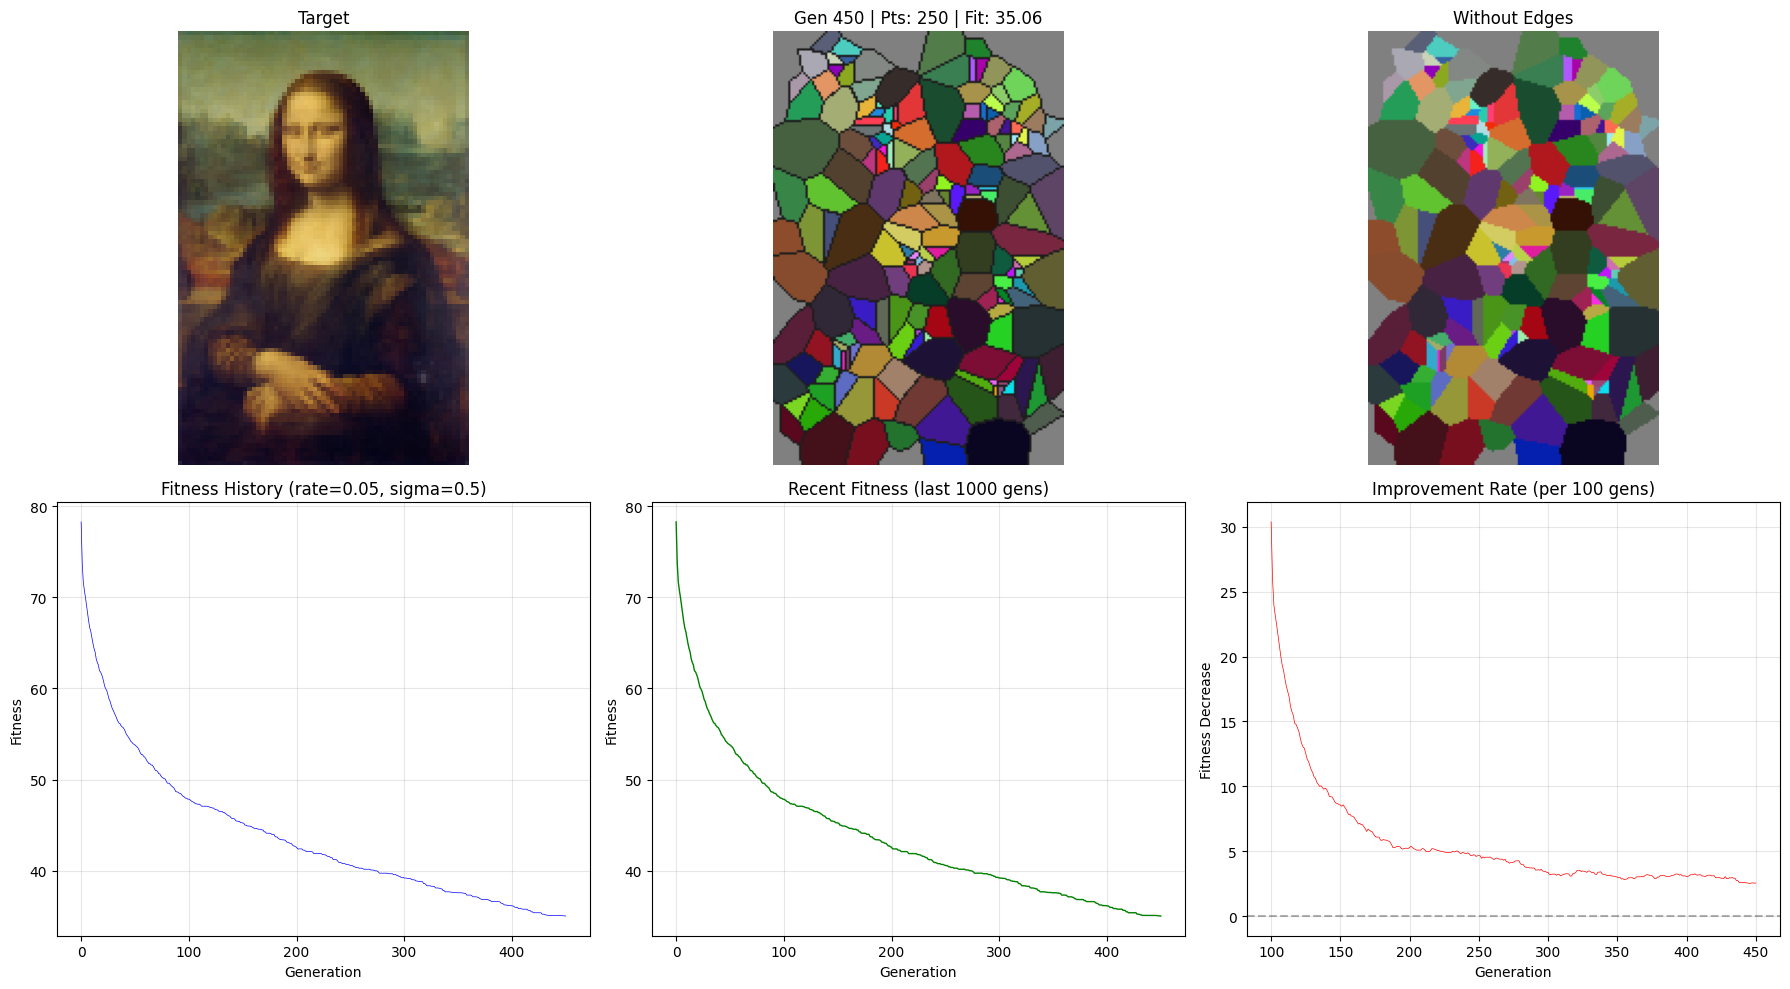

In [ ]:
global_gen = 0
history = []

for i, phase in enumerate(config["phases"]):
    print(f"\nPhase {i+1}/{len(config['phases'])}: {phase['gens']} gens, rate={phase['rate']}, sigma={phase['sigma']}, action={phase.get('action')}")
    population, global_gen, history = run_phase(
        population, target_img, config, phase, global_gen, run_dir, history
    )

print("\n" + "="*50)
print("Evolution complete!")
print(f"Final generation: {global_gen}")
print(f"Final fitness: {select_best(population)['fitness']:.2f}")
print(f"Final points: {len(population[0]['points'])}")

---
## Resume from Checkpoint (Optional)
Run these cells instead of the above if resuming

In [ ]:
# # CHANGE THIS PATH to your checkpoint
# checkpoint_path = "./output/run_XXXXXXXX_XXXXXX/checkpoint_05000.pkl"

# with open(checkpoint_path, "rb") as f:
#     checkpoint = pickle.load(f)

# population = checkpoint["population"]
# history = checkpoint["history"]
# start_gen = checkpoint["generation"]
# config = checkpoint["config"]
# run_dir = os.path.dirname(checkpoint_path)

# print(f"Resumed from generation {start_gen}")
# print(f"Points: {len(population[0]['points'])}")
# print(f"Best fitness: {select_best(population)['fitness']:.2f}")
# print(f"History length: {len(history)}")

In [ ]:
# # Define additional phases to run
# extended_phases = [
#     {"gens": 2000, "rate": 0.003, "sigma": 0.2, "action": None},
#     {"gens": 1, "rate": 0.003, "sigma": 0.2, "action": "duplicate"},
#     {"gens": 2000, "rate": 0.002, "sigma": 0.15, "action": None},
#     {"gens": 2000, "rate": 0.001, "sigma": 0.1, "action": None},
# ]

# global_gen = start_gen

# for i, phase in enumerate(extended_phases):
#     print(f"\nExtended Phase {i+1}/{len(extended_phases)}: {phase['gens']} gens, rate={phase['rate']}, sigma={phase['sigma']}")
#     population, global_gen, history = run_phase(
#         population, target_img, config, phase, global_gen, run_dir, history
#     )

# print("\n" + "="*50)
# print("Extended evolution complete!")
# print(f"Final generation: {global_gen}")
# print(f"Final fitness: {select_best(population)['fitness']:.2f}")

---
## Final Result

In [ ]:
best = select_best(population)
clean_history = [h for h in history if h is not None]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(target_img)
axes[0, 0].set_title("Target")
axes[0, 0].axis("off")

axes[0, 1].imshow(render_painting(best, scale=3, with_edges=False))
axes[0, 1].set_title(f"No Edges ({len(best['points'])} points)")
axes[0, 1].axis("off")

axes[0, 2].imshow(render_painting(best, scale=3, with_edges=True))
axes[0, 2].set_title("Stained Glass")
axes[0, 2].axis("off")

axes[1, 0].plot(clean_history, 'b-', linewidth=0.5)
axes[1, 0].set_title("Full Fitness History")
axes[1, 0].set_xlabel("Generation")
axes[1, 0].set_ylabel("Fitness")
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].semilogy(clean_history, 'g-', linewidth=0.5)
axes[1, 1].set_title("Fitness (Log Scale)")
axes[1, 1].set_xlabel("Generation")
axes[1, 1].set_ylabel("Fitness")
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].axis("off")

plt.tight_layout()
plt.savefig(os.path.join(run_dir, "final_result.png"), dpi=150)
plt.show()

print(f"\nFinal Statistics")
print(f"─────────────────")
print(f"Generations: {len(clean_history)}")
print(f"Final Fitness: {best['fitness']:.2f}")
print(f"Initial Fitness: {clean_history[0]:.2f}")
print(f"Improvement: {((clean_history[0] - best['fitness']) / clean_history[0] * 100):.1f}%")
print(f"Points: {len(best['points'])}")
print(f"Min Fitness: {min(clean_history):.2f}")

save_checkpoint(population, history, config, run_dir, len(clean_history))
print(f"\nSaved final checkpoint to {run_dir}")

## High Resolution Export

In [ ]:
best = select_best(population)

for scale in [5, 10]:
    img_edges = render_painting(best, scale=scale, with_edges=True)
    img_no_edges = render_painting(best, scale=scale, with_edges=False)
    
    img_edges.save(os.path.join(run_dir, f"final_edges_{scale}x.png"))
    img_no_edges.save(os.path.join(run_dir, f"final_smooth_{scale}x.png"))
    
    print(f"Saved {scale}x versions ({img_edges.size[0]}x{img_edges.size[1]})")

## Create GIF

In [ ]:
frames = []
image_files = sorted([f for f in os.listdir(run_dir) if f.startswith("gen_") and f.endswith(".png")])

print(f"Found {len(image_files)} frames")

for filename in image_files:
    frames.append(imageio.imread(os.path.join(run_dir, filename)))

for _ in range(20):
    frames.append(frames[-1])

gif_path = os.path.join(run_dir, "evolution.gif")
imageio.mimsave(gif_path, frames, fps=10)
print(f"Saved: {gif_path}")